In [154]:
import control as ctrl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import sympy as sp

In [155]:
plt.style.use(plt.style.available[9])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [156]:
class DeepNetwork(torch.nn.Module):
    def __init__(self, input_dim=8, hidden_dims=[128, 128, 128], num_classes=5):
        super(DeepNetwork, self).__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        
        # Build the hidden layers
        for i in range(len(dims) - 1):
            layers.append(torch.nn.Linear(dims[i], dims[i + 1]))
            layers.append(torch.nn.ReLU())
        
        # Output layer
        layers.append(torch.nn.Linear(dims[-1], num_classes))
        
        # Sequentially stack the layers
        self.model = torch.nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [157]:
numerator = [40]
denominator = [1, 1]
H_s = ctrl.tf(numerator,denominator)
H_s

TransferFunction(array([40]), array([1, 1]))

In [158]:
# Example white noise input signal
torch.manual_seed(42)
input_signal = np.random.rand(5000)
time = np.arange(0, 10, 0.002)

# Generate system response using control library
T, y_out = ctrl.forced_response(H_s, T=time, U=input_signal)
y_out = (y_out - np.min(y_out)) / (np.max(y_out) - np.min(y_out))

print(f'input_signal shape: {input_signal.shape}')
print(f'ouput signal shape: {y_out.shape}')

input_signal shape: (5000,)
ouput signal shape: (5000,)


In [159]:
y = torch.from_numpy(input_signal).reshape(-1, 1).to(device).float()
x = torch.from_numpy(y_out).reshape(-1, 1).to(device).float()
X = torch.cat([x, y], dim=1)

model = DeepNetwork(input_dim=X.shape[1], hidden_dims=[256], num_classes=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    if epoch %5000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.9836638569831848
Epoch 5000, Loss: 2.387383801760734e-07
Epoch 10000, Loss: 4.4800267460232135e-06
Epoch 15000, Loss: 4.2709054071110586e-08
Epoch 20000, Loss: 3.0168457954005135e-08
Epoch 25000, Loss: 2.448078184613678e-08
Epoch 30000, Loss: 2.298671475386982e-08
Epoch 35000, Loss: 2.0571770065203054e-08
Epoch 40000, Loss: 2.9734860618191306e-06
Epoch 45000, Loss: 1.4390427516275395e-08


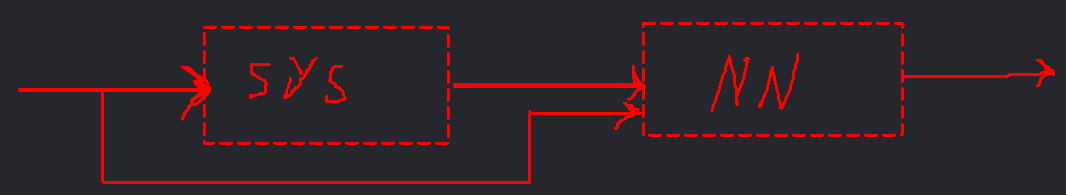

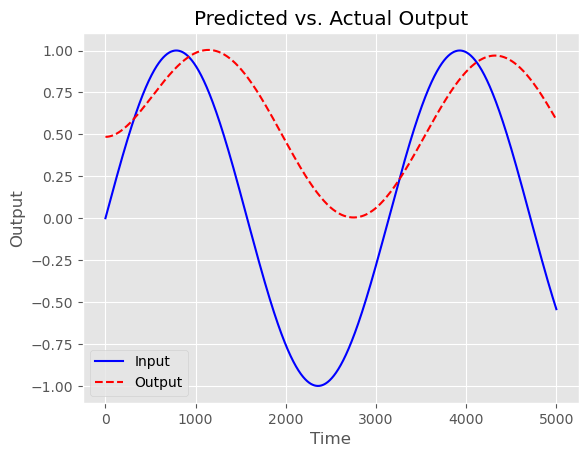

In [160]:
input_test = np.sin(time)

T, y_test = ctrl.forced_response(H_s, T=time, U=input_test)

y_test = (y_test - np.min(y_test)) / (np.max(y_test) - np.min(y_test))
y = torch.from_numpy(y_test).reshape(-1,1).to(device).float()
x = torch.from_numpy(input_test).to(device).float().reshape(-1, 1)

X = torch.cat([y, y], dim=1)

out = model(X)


plt.plot(input_test, label="Input", color="blue")
plt.plot(out.detach().cpu().numpy(), label="Output", color="red", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Output")
plt.legend()
plt.title("Predicted vs. Actual Output")
plt.show()

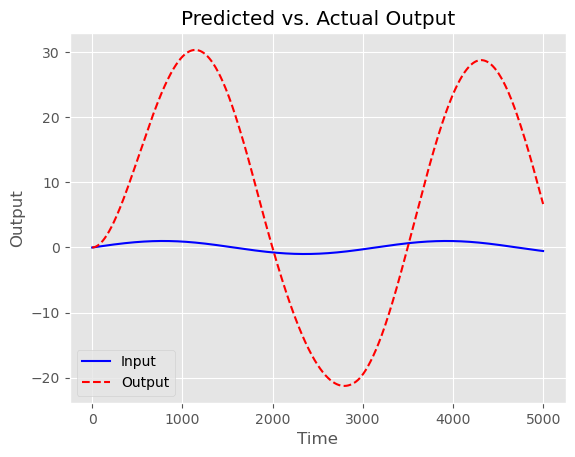

In [161]:
input_test = np.sin(time)

x = torch.from_numpy(input_test).to(device).float().reshape(-1, 1)
X = torch.cat([x, x], dim=1)

out = model(X)

T, y_test = ctrl.forced_response(H_s, T=time, U=out.detach().reshape(-1,).cpu().numpy())

plt.plot(input_test, label="Input", color="blue")
plt.plot(y_test, label="Output", color="red", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Output")
plt.legend()
plt.title("Predicted vs. Actual Output")
plt.show()